![](dogecoin.jpg "Dogecoin")

![Dogecoin](images/dogecoin.jpeg)

# Overview

A hedgefund is seeking to profit from the volatility and inefficiences of the cryptocurrency market. They would like to focus on Dogecoin, a cryptocurrency with a $30B market cap. Their marketing team desires to better understand the sentiment around dogecoin, for understanding other owners and what words or phrases most reseonate with them. 

Dogecoin began as satire, using a meme of a Shiba Inu dog misspelled as "doge." The makers, Billy Marcus and Jackson Palmer, created it in late 2013. Then launched a large campaing including sending the Jamaican Bobled team to the '14 olympics and sponsoring a Nascar. 

As a cryptocurrency, Dogecoin also relies on block-chain cryptography. All coin holder's carry a ledger. And miner's have to solve mathproblems to create new chains. They are rewarded with dogecoin. 

Dogecoin differs from many other cryptocurrency in that it has no lifetime cap on the number of coins that can be produced. This means it is highly inflationary--by design. This diminishes the coin as a store of value, but increases its use as an actual currency. 

# Business Understanding

Market volatililty and the speculative nature of Dogecoin increase risk of owning asset. Since the price of other cryptocurrencies have proven susceptible to the sentiment of its buyers and sellers (citation), the hedfund seeks deeper comprehension of the sentiment of those very buyers and seller, in order to get a better grasp on the market, and possibly leverage that information for profits in the future. This project uses Twitter as a proxy for the buyers and sellers, and analyzes tweets containing the word "dogecoin." 

# Data Understanding

Twitter API, Tweets, Features, Target

Twitter's API has limitations on retrieval. One can only pull tweets from the last 7days, in increments of 180 tweets every 15 minuts, with a cap of 2,600 at one time. Thus, it takes 3 and 1/2 hours to pull accumulate 2,500 tweets. 

Retweets will be excluded because the Hedgefund is trying to get a sense of dogecoin audience, not the retweets of one bot (which we discovered within our first few pulls).

### Twitter API Request Code
```
# Authentication
consumerKey = creds['API Key']
consumerSecret = creds['API Key Secret']
accessToken = creds['Access Token']
accessTokenSecret = creds['Access Token Secret']
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

#Pull tweets based on Keyword and Amount (noOfTweet)
keyword = input('Please enter keyword or hastag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
tweets = tweepy.Cursor(api.search_tweets, q=keyword+' -filter:retweets').items(noOfTweet)
tweet_list = []
tweet_date_list = []
for tweet in tweets:
    tweet_list.append(tweet.text)
    tweet_date_list.append(tweet.created_at)

tweet_list = pd.DataFrame(tweet_list)

```

### Imports

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
import json

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

### Concatenate Tweets
Because Twitter's API has a limit, we had to pull tweets in batches. Below, we concatenate all these serparate pulls. 

In [19]:
df_1 = pd.DataFrame(pd.read_csv('data/doge_tweets_111621_1138',index_col=0)['text'])
df_2 = pd.DataFrame(pd.read_csv('data/dogecoin2_11_16_21_1pm.csv',index_col=0)['text'])
df_3 = pd.DataFrame(pd.read_csv('data/dogecoin_11_17_21_10am.csv', index_col=0)['text'])
df=pd.concat([df_1,df_2, df_3])
df.drop_duplicates(inplace=True)
df

,text
0,@binance @BinanceChain @dogecoin
1,@DogecoinNorway @occupymars42069 @dogeofficial...
2,"16 November 2021, 07:36h \r\n\r\nThe current p..."
3,Give some tip today to a friend or family memb...
4,@Jayecane Help everyone by getting them into #...
...,...
994,RT @SahariCharity: DYOR @racoontoken_ #Racoon...
996,RT @TravisNTravesty: @Outerspacefris1 This is ...
997,Amk bulastik bi coin isine ipnenin zevkini bek...
998,@Vrom14286662 @bitcoin43 @Bitcoin @litecoin @d...


## Write a function for vectorizing
Note, this function removes stopwords and sorts the vectorized  

removed stopwords

In [138]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words = 'english',max_df=1.0, min_df=0.01).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], bag_of_words

In [139]:
def get_top_n_gram_test(corpus, trained_corpus, ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words = 'english',max_df=1.0, min_df=0.01).fit(trained_corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], bag_of_words

## Clean Tweets
We removed punctuation, in order to track similar words. Likewise, we made every word lower case.

In [43]:
# Remove RT
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
# Remove punctuation
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)"," ",x)
# Remove Retweets
df["clean_text"] = df.text.map(remove_rt).map(rt)
# Lower the case 
df["clean_text"] = df.clean_text.str.lower()


In [29]:
#Calculating Negative, Positive, Neutral and Compound values
df_probs = pd.DataFrame()
df_probs[['polarity', 'subjectivity']] = df['clean_text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in df['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_probs.loc[index, 'sentiment'] = 0
    elif pos > neg:
        df_probs.loc[index, 'sentiment'] = 1
    else:
        df_probs.loc[index, 'sentiment'] = 0
df_probs.head(10)

,polarity,subjectivity,sentiment
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0
2,0.000000,0.350000,0.0
3,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0
5,0.000000,0.000000,0.0
6,0.309028,0.729167,0.0
7,0.445455,0.351515,0.0
8,-0.400000,0.400000,0.0
9,0.000000,0.000000,0.0


In [74]:
df.reset_index(drop=True, inplace=True)
df_pos = df[['text']]
df_probs.reset_index(drop=True, inplace=True)
df_pos['sentiment'] = df_probs['sentiment']
df_pos = df_pos[df_pos['sentiment'] == 1]


,text
0,@binance @BinanceChain @dogecoin
1,@DogecoinNorway @occupymars42069 @dogeofficial...
2,"16 November 2021, 07:36h \r\n\r\nThe current p..."
3,Give some tip today to a friend or family memb...
4,@Jayecane Help everyone by getting them into #...
...,...
3095,RT @SahariCharity: DYOR @racoontoken_ #Racoon...
3096,RT @TravisNTravesty: @Outerspacefris1 This is ...
3097,Amk bulastik bi coin isine ipnenin zevkini bek...
3098,@Vrom14286662 @bitcoin43 @Bitcoin @litecoin @d...


In [80]:
# Remove RT
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
# Remove punctuation
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)"," ",x)
# Remove Retweets
df_pos["clean_text"] = df_pos.text.map(remove_rt).map(rt).copy(deep=True)
# Lower the case 
df_pos["clean_text"] = df_pos.clean_text.str.lower().copy(deep=True)


<ipython-input-80-f308b8778706>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos["clean_text"] = df_pos.text.map(remove_rt).map(rt).copy(deep=True)
<ipython-input-80-f308b8778706>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos["clean_text"] = df_pos.clean_text.str.lower().copy(deep=True)


In [97]:
positives, pos_vec = get_top_n_gram(df_pos['clean_text'], (1,1), 100)
positives = [X[0] for X in positives]
print(positives)

['dogecoin', 'project', 'doge', 'new', 'earn', 'friend', 'income', 'pasive', 'day', '10', 'support', 'twitter', 'dogecoins', 'a6n4rywnuahiy9nncneozajbgc2opmkqmo', 'facebook', 'instagram', 'gift', 'socialmedia', 'bitcoin', 'whale', 'pinterest', 'ba', 'crypto', 'swap', 'alert', 'tx', 'gifts', 'deal', 'good', 'like', 'price', 'catecoin', 'linkedin', 'current', 'tumblr', 'btc', 'shiba', 'update', 'great', 'token', 'don', 'eth', 'io', 'moon', 'shib', 'just', 'ethereum', 'ready', 'dogearmy', 'future', 'buy', 'birthdaygirl', 'affiliatemarketing', 'worth', 'free', 'amp', 'value', 'usd', 'happy', 'nft', 'empire', 'add', 'addr', 'change', 'make', 'amazing', 'dep', 'awesome', 'cryptocurrency', 'shibainu', 'best', 'legacy', 'says', 'minute', 'hour', 'important', 'community', 'love', 'inu', 'coming', 'ev', 'tippingtuesday', 'join', 'ad', 'global', 'let', 'mdoge', 'social', 'coins', 'devs', 'accept', 'market', 'better', 'birthday', 'cash', 'think', 'time', 'binance', 'looking', 'miss']


In [98]:
from nltk import sent_tokenize
from nltk import word_tokenize

def extract_features(text, top_100):
    sia = SentimentIntensityAnalyzer()
    features = dict()
    wordcount = 0
    compound_scores = list()
    positive_scores = list()

    for sentence in sent_tokenize(text):
        for word in word_tokenize(sentence):
            if word.lower() in top_100:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])

    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers you'll use later don't work with negative numbers.
    features["mean_compound"] = np.mean(compound_scores) + 1
    features["mean_positive"] = np.mean(positive_scores)
    features["wordcount"] = wordcount

    return features['wordcount']

features = [
    (extract_features(review, positives))
    for review in df['clean_text']]

C:\Users\andy.schmeck.OFFICE\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\andy.schmeck.OFFICE\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
features

In [113]:
df_feat = pd.concat([df['clean_text'], pd.DataFrame(features)], axis=1)
df_feat['clean_text'].head(50)

0                                                      
1                           oh  dogecoin i luv you     
2     16 november 2021  07 36h     the current price...
3     give some tip today to a friend or family memb...
4       help everyone by getting them into  dogecoin...
5        messi  binance  bitcoin  eysevgili  sezaika...
6       i agree  the original dogecoin community was...
7       empire haha i don t even have money to buy a...
8                 once  shibarium launches  it s gam...
9      webtalk  bitcoin  tumblr  twitter  facebook  ...
10     linkedin  twitter  facebook  instagram  tikto...
11     entrepreneurs  selfemployed  traveling  affil...
12     linkedin  twitter  facebook  instagram  bitco...
13     tumblr  twitter  facebook  instagram  dogecoi...
14     linkedin  twitter  facebook  instagram  dogec...
15     businessman  tumblr  twitter  facebook  insta...
16     businessman  tumblr  twitter  facebook  insta...
17     businessman  blogs  blogger  tumblr  twit

In [114]:
# Train-test split
X_train,X_test,y_train,y_test = train_test_split(df_feat, df_probs['sentiment'],random_state=1)
# top_list,vec = get_top_n_gram(X_train['text'], (2,3),500)
X_train

,clean_text,0
2803,babydogepaid airdrops joining get 100 00...,4
866,dogecoin whale alert tx 26...,5
674,linkedin twitter facebook instagram tikto...,10
468,let s look at the top 3 meme based gainers of ...,2
1299,of bsc catecoin the king of meme i...,2
...,...,...
2763,current doge price is 0 23776 dogecoin cry...,5
905,not so mr wonderful says dogecoin holders di...,2
1096,dilshad ba swap my friend there is a new ...,10
235,saitama shiba i ll have all the ca...,1


In [140]:
feat, feat_vec_train = get_top_n_gram(X_train['clean_text'], (1,1), 100)
feat, feat_vec_test = get_top_n_gram_test(X_test['clean_text'], X_train['clean_text'], (1,1), 100)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_vec = pd.concat([X_train[0], pd.DataFrame(feat_vec_train.todense())], axis=1)
X_test_vec = pd.concat([X_test[0], pd.DataFrame(feat_vec_test.todense())], axis=1)

In [134]:
X_train_vec

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,10,0,0,0,0,0,1,1,1,1,1,1,0,1,0,1,0,1
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,5,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2321,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2322,10,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2323,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Baseline

Our baseline is the average of the majority class, which is 68% neutral/negative. 

In [136]:
(1- y_train.sum()/y_train.shape[0])*100

vec.shape

(3100, 21137)

## the Model

In [141]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec,y_train)

#Cross-Validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(nb, X_train_vec, y_train))

# Predictions
y_preds = nb.predict(X_test_vec)
df_fin = pd.DataFrame()
df_fin['predictions'] = y_preds
print(df_fin.value_counts('predictions'))

# Metric
print('Accuracy Score:',accuracy_score(y_test,df_fin['predictions']))

[0.72258065 0.68172043 0.71827957 0.67311828 0.70322581]
predictions
0.0    556
1.0    219
dtype: int64
Accuracy Score: 0.7264516129032258


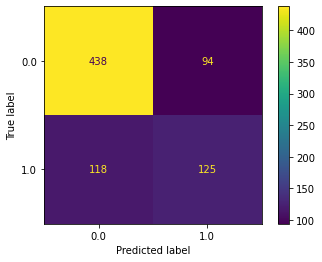

In [143]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb, X_test_vec, y_test)

# Recommendations

We recommend using these words and phrases. 

They mean this. 

# Future Research

Going forward, we would love to offer sentiment analysis over time, along with the quantity of tweets at any given time, to predict price changes. 

We also would love to anaylze different excahnges. for example, reddit's wall street bets often trades in Robinhood. So doing a comparative sentiment analysis might help with arbitrage of dogecoin or between other currencies. 